In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.neutral_transport import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Hermes IO

In [2]:
casestore = dict()

## Note that case actually all have ie as well

In [3]:
db = CaseDB()

toload = [
    # dict(name="ii_ee_cx", id="xcol1b-ii_ee_cx_only", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="ii_ee_en", id="xcol1c-ii_ee_en_only", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="ii_ee_ni", id="xcol1d-ii_ee_ni_only", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="ii_ee_nn", id="xcol1e-ii_ee_nn_only", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="ii_ee_cx_en_ni_nn", id="xcol1f-ii_ee_cx_en_ni_nn", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="ii_ee", id="xcol1g-ii_ee_only", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="base", id="xcol1a-base-tests", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
 
        
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.607E+00 [m3]


- Hermes-3 effective temperature looks wrong

In [4]:
ds = casestore["base"].ds
ds = calculate_radial_fluxes(ds)

# Make functions for whole domain

## Rates

2D data detected
*****************************
Excel saves precision as it appears, not as what the number has.......
*****************************


Text(0, 0.5, 'Collision frequency ${\\alpha}$ $[s^{-1}]$')

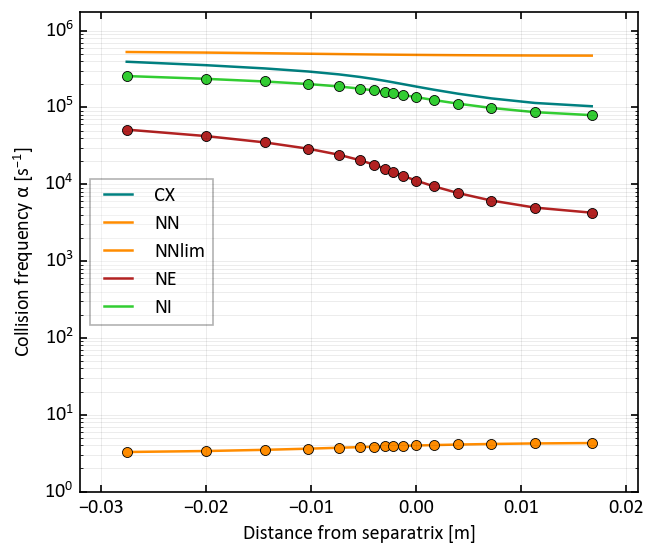

In [5]:

plt.style.use(r"C:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\Lib\site-packages\matplotlib\mpl-data\stylelib\mike.mplstyle")

domain = ds
m = ds.metadata
Te = domain["Te"].values
Ta = domain["Td"].values
Ti = domain["Td+"].values
Ne = domain["Ne"].values
Na = domain["Nd"].values
Pa = domain["Pd"].values
Dn = domain["Dnnd"].values
Fa = domain["NVd"].values
Fi = domain["NVd+"].values

neut = NeutralTransport(domain)
neut.get_rates(Te, Ta, Ti, Ne, Na)
rates = neut.k

# Put rate back into dataset
for rate in rates:
    ds[rate] = (["x", "theta"], rates[rate])
    ds[rate].attrs["metadata"] = ds.metadata

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

fig, ax = plt.subplots()

ax.plot(dist, omp["cx"], label = "CX")
ax.plot(dist, omp["nn"], label = "NN", c = "darkorange")
ax.plot(dist, omp["Kdd_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "darkorange")
ax.plot(dist, omp["nnlim"], label = "NNlim")
ax.plot(dist, omp["ne"], label = "NE", c = "firebrick")
ax.plot(dist, omp["Kde_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "firebrick")
ax.plot(dist, omp["ni"], label = "NI", c = "limegreen")
ax.plot(dist, omp["Kdd+_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "limegreen")
# ax.plot(dist, domain["Fdd+_cx"], label = "Hermes-3", marker = "o", lw = 0)
# ax.plot(dist, Dn_cx*1.0, label = "Reconstructionst
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Collision frequency ${\\alpha}$ $[s^{-1}]$")

### Diffusion

Text(0, 0.5, 'Neutral diffusion coefficient [$m^2$/s]')

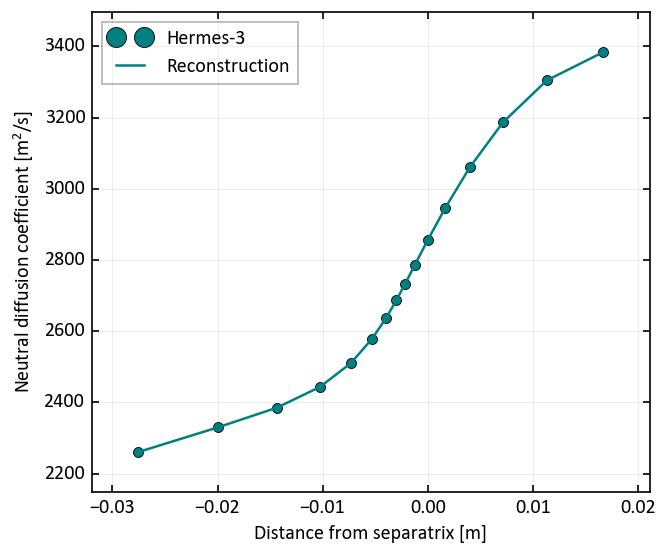

In [7]:
fig, ax = plt.subplots()
neut.get_Dn(Ta, collisions = ["cx", "nn", "ne", "ni", "nnlim"])
ds["Dn_calc"] = (["x", "theta"], neut.Dn)
ds["Dn_calc"].attrs["metadata"] = ds.metadata

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

plt.plot(dist, omp["Dnnd"], label = "Hermes-3", marker = "o", c = "teal", lw = 0)
plt.plot(dist, omp["Dn_calc"], label = "Reconstruction", c = "teal")
ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral diffusion coefficient [$m^2$/s]")
# ax.set_yscale("log")

## Fluxes

Text(0, 0.5, 'Radial neutral flux $[m^{2}s^{-1}]$')

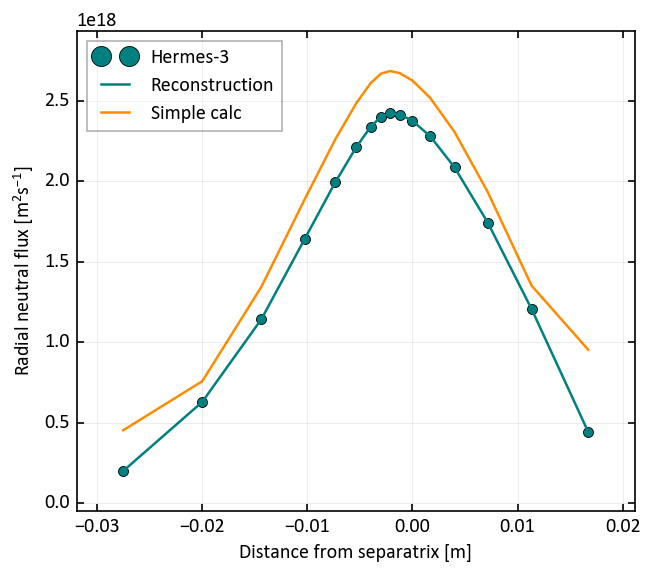

In [32]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\Lib\site-packages\matplotlib\mpl-data\stylelib\mike.mplstyle")
fig, ax = plt.subplots()
# grad_Pa = np.gradient(Pa, dist)

ds["newflux_L"], ds["newflux_R"] = Div_a_Grad_perp_fast(ds, ds[f"Dn_calc"]*ds[f"Nd"], np.log(ds["Pd"]))

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])
da = omp["dy"] * omp["dz"] #omp["J"] * omp["g11"] * omp["dy"]

flux_simple = omp["Dn_calc"] * omp["Nd"] * np.gradient(omp["Pd"], dist) / omp["Pd"] / da
flux_ref = (omp["pf_perp_diff_R_d"] + omp["pf_perp_diff_L_d"])/2
flux_calc = (omp["newflux_R"] + omp["newflux_L"])/2

ax.plot(dist, -flux_ref / (da), label = "Hermes-3", marker = "o", c = "teal", lw = 0)
plt.plot(dist, -flux_calc / (da), label = "Reconstruction", c = "teal")
ax.plot(dist, flux_simple, label = "Simple calc", c = "darkorange")
ax.legend()
# ax.set_ymargin(0.1)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
# ax.set_yscale("log")

In [4]:
ds["newflux_L"], ds["newflux_R"] = Div_a_Grad_perp_fast(ds, ds[f"Dn_calc"]*ds[f"Nd"], np.log(ds["Pd"]))

NameError: name 'omp' is not defined